# Conformal Prediction with LSTM base model and Random Forest Regressor for GBTC ETF
Conformal prediction is a relatively new framework for quantifying uncertainty in the predictions made by
arbitrary prediction algorithms. Fundamentally, it does so by converting an algorithm’s predictions into
prediction sets, which have strong finite-sample coverage properties. A new framework was recently developped for time series forcasting which doesn't require exchangeability of the data. [More details and citations on this in our final report]

We use conformal prediction to predict an interval around the prediction with (1-alpha) confidence level. This enables us to build confidence in our prediction and define a probability threshold for our trading decision.

Conformal prediction can be used in addition to any machine learning model. In this project, we applied the method to several regressors. This notebook first uses a LSTM - extending the LSTM model previously developped as a point value predictor. The prediction performance is then compared to a Random Forest Regressor.


## Data cleaning and preprocessing

The class Preprocessing defined in the Data_preprocessing.py python file defines the main methods for the data cleaning, handling missing values, preprocessing the historical data to feed into the models.

In this project, a prediction is made using the data from the 3 previous days and the open of the current day. Historical data from GBTC value and other crypto assets was gathered from Yahoo Finance.

In [1]:
from Data_preprocessing import Preprocessing
preprocessing = Preprocessing(timestep=3)

In [2]:
x, y, xscaler, yscaler = preprocessing._load_and_preprocess_data('GBTC',  ['ETCG'])
x_train, x_test, y_train, y_test, x_last = preprocessing._chunking(x, y)

         Date  Open  High   Low  Close  Adj Close   Volume  Open_ETCG  \
0  2019-11-22  8.63  9.29  8.53   9.27       9.27  4922600       9.10   
1  2019-11-25  9.15  9.45  8.92   9.04       9.04  3050000       9.06   
2  2019-11-26  8.95  9.03  8.91   9.00       9.00  1446100       9.20   
3  2019-11-27  9.04  9.74  9.04   9.58       9.58  3452200       9.07   
4  2019-11-29  9.77  9.89  9.55   9.57       9.57  2272600       9.55   

   High_ETCG  Low_ETCG  Close_ETCG  Adj Close_ETCG  Volume_ETCG  
0       9.35      8.61       9.053           9.053        28200  
1       9.25      8.83       9.100           9.100        22300  
2       9.28      9.10       9.160           9.160         4100  
3       9.90      9.07       9.502           9.502        26300  
4       9.89      9.55       9.890           9.890         1400  


## LSTM Neural Network
The model and its main methods are defined in the LSTM class inside the Conformal_LSTM.py python file. Methods are implemented to build, train the model and then predict the high for today or for a time interval for back testing.

In [3]:
from conformal_LSTM import LSTM_Predictor
LSTM = LSTM_Predictor(xscaler, yscaler, x_last)

For time series conformal prediction we use the mapie library available at: https://github.com/scikit-learn-contrib/MAPIE/tree/master. The library is compatible with scikit-learn model so our Tensorflow is wrapped using scikeras.wrapper. We use the funtion MapieTimeSeriesRegressor with method='EnbPI' for our prediction intervals.

The model is trained for 100 epochs using loss MSE and Adam optimizer.

We use the BlockBootstrap sampling method instead of the traditional bootstrap strategy for training the model since the former is more suited for time series data. Here, we choose to perform 10 resamplings with 10 blocks

In [4]:
LSTM._create(x_train.shape)
LSTM._train(x_train, y_train)

C:\Users\meuni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 12)          │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 12)          │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 6)           │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,980 (11.64 KB)

 Trainable params: 2,980 (11.64 KB)

 Non-trainable params: 0 (0.00 B)

C:\Users\meuni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


None


C:\Users\meuni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.9682 - val_loss: 1.0946
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9545 - val_loss: 1.0797
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9431 - val_loss: 1.0608
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8953 - val_loss: 1.0351
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9028 - val_loss: 0.9976
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8864 - val_loss: 0.9449
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8013 - val_loss: 0.8750
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7358 - val_loss: 0.7877
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6552 - val_loss: 0.6901
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5736 - val_loss: 0.5920
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4854 - val_loss: 0.5010
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3952 - val_loss: 0.4

C:\Users\meuni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\meuni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mapie\utils.py:542: UserWarning: WARNING: at least one point of training set belongs to every resamplings.
Increase the number of resamplings
  warnings.warn(
C:\Users\meuni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mapie\aggregation_functions.py:116: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(X, axis=1)


The function defining the trading strategy is a method from the preprocessing class. It also includes a method to plot the predictions from our different models with their prediction intervals.

In [5]:
probability_threshold = 0.60  # Probability threshold (e.g., 60%) for trading strategy
alpha = 2 * (1 - probability_threshold)

lstm_point_pred, lstm_point_lb, lstm_test_pred, lstm_test_interval = LSTM._predict(x_test=x_test, alpha = alpha)

print(f"Predicted High: {lstm_point_pred}")
print(f"Predicted {probability_threshold*100}% lower bound: {lstm_point_lb}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


C:\Users\meuni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mapie\estimator\estimator.py:297: RuntimeWarning: All-NaN slice encountered
  return phi2D(A=x, B=k, fun=lambda x: np.nanmedian(x, axis=1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  
Predicted High: 56.43583679199219
Predicted 60.0% lower bound: 56.07348172192633


C:\Users\meuni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\mapie\estimator\estimator.py:297: RuntimeWarning: All-NaN slice encountered
  return phi2D(A=x, B=k, fun=lambda x: np.nanmedian(x, axis=1))


In [6]:
import json
todays_open = json.load(open('./data/todays/GBTC.json'))['open']
print(f"Today's open is: {todays_open}")

trade = preprocessing._enter_trade(lstm_point_lb, todays_open)
if trade:
    print("Enter trade")
else:
    print("Do not enter trade")


Today's open is: 55.650001525878906
Do not enter trade


We evaluate the model by calculating the loss on unseen data. To visualize the confidence improvement made using conformal prediction, we plot the prediction for a testing time interval.

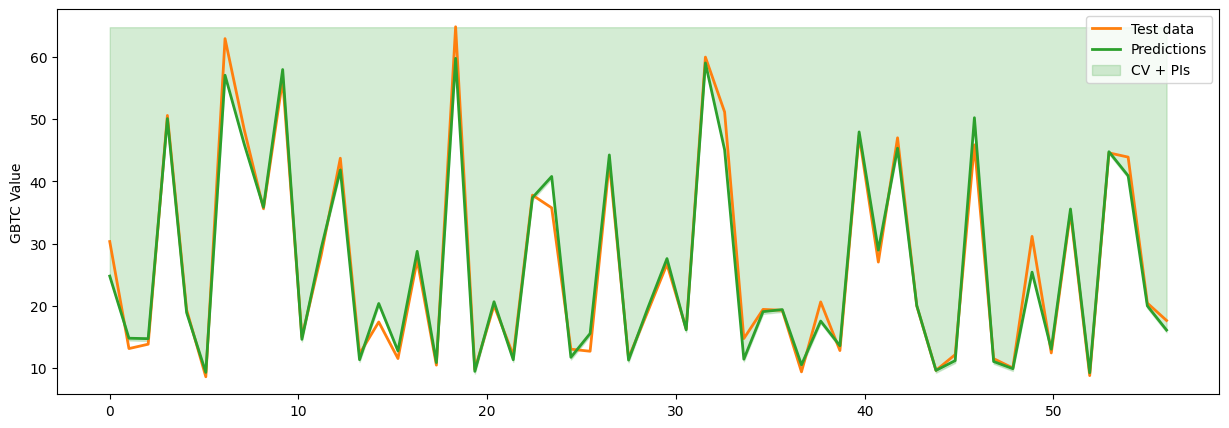

In [7]:
preprocessing.plot_with_interval(y_test, lstm_test_pred, lstm_test_interval)

In [8]:
mean_error = preprocessing.performance_conformal(y_test, lstm_test_interval)
print(f"The high of the day was outside of the one-sided predicted interval {mean_error*100}% of the tested days")

The high of the day was outside of the one-sided predicted interval 41.07142857142857% of the tested days


When using the EnbPI method, to improve the fit of the prediction interval, we can update the residuals during the prediction, each time new observations are available so that the deterioration of predictions, or the increase of noise level, can be dynamically taken into account. It can be done with MapieTimeSeriesRegressor through the partial_fit class method called at every step.

Implementing this could be a way forward for this project.

## Random Forest Regressor
The model and its main methods are defined in the RFRegressor class inside the Conformal_RF.py python file. Methods are implemented to build, train the model and then predict the high for today or for a time interval for back testing.

For this model, partial fit was implemented.

To feed the data into the RF regressor it must be a 2D array so x data is reshaped.

In [9]:
from conformal_RF import RFRegressor
RF = RFRegressor(xscaler, yscaler, x_last)

To tune the Random Forest Regressor we perform a hyperparameter random search when calling the method _params_fit

In [10]:
RF._params_fit(x_train, y_train)
RF._train(x_train, y_train)

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=11, n_estimators=80, random_state=59)>


In [11]:
rf_point_pred, rf_point_lb, rf_test_pred, rf_test_interval = RF._predict(x_test)
rf_test_pred_pf, rf_test_interval_pf = RF._partial_fit(x_test, y_test, gap=1)

In [12]:
print(f"Predicted High: {rf_point_pred}")
print(f"Predicted {probability_threshold*100}% lower bound: {rf_point_lb}")
print(f"Today's open is: {todays_open}")

trade = preprocessing._enter_trade(rf_point_lb, todays_open)
if trade:
    print("Enter trade")
else:
    print("Do not enter trade")

Predicted High: 56.312875509262085
Predicted 60.0% lower bound: 56.039418310934586
Today's open is: 55.650001525878906
Do not enter trade


We evaluate the model on the same data as we did for the LSTM.

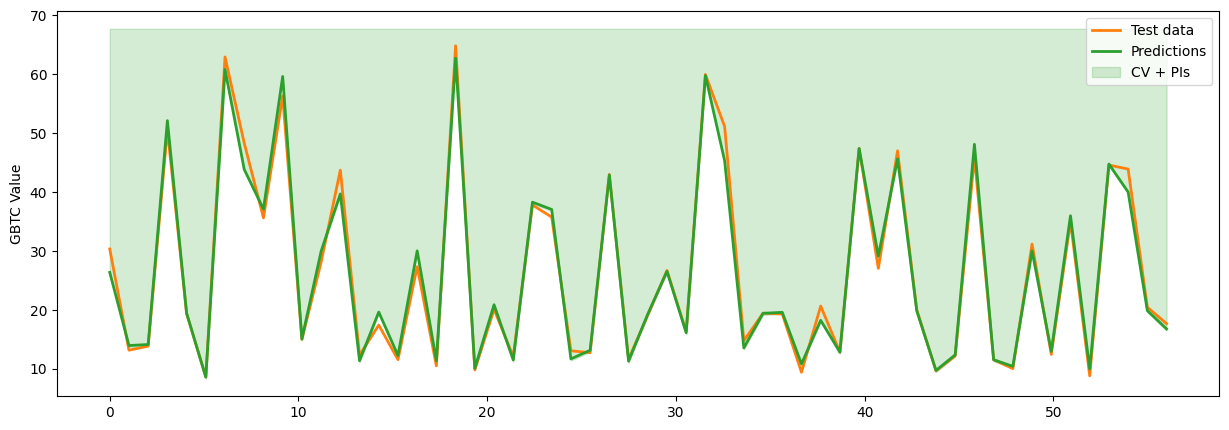

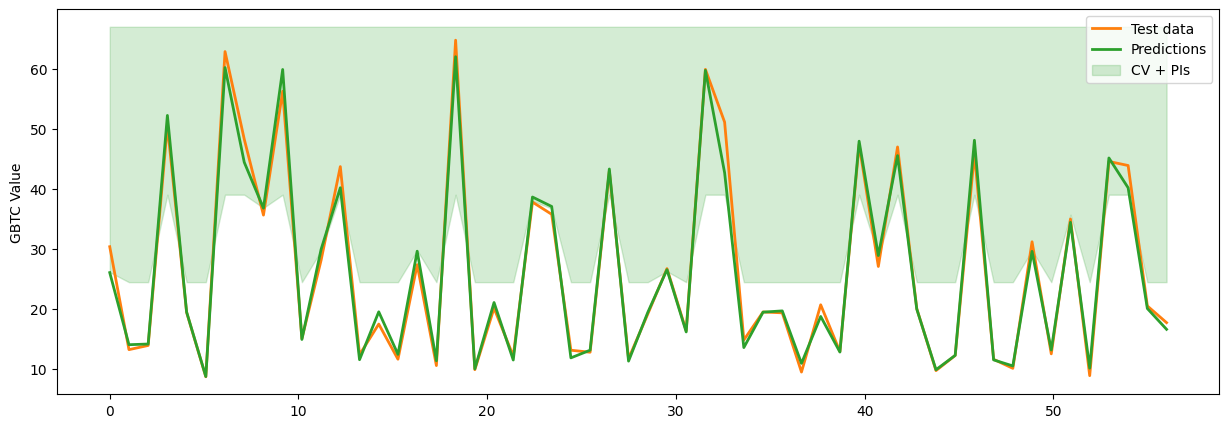

In [13]:
preprocessing.plot_with_interval(y_test, rf_test_pred, rf_test_interval)
preprocessing.plot_with_interval(y_test, rf_test_pred_pf, rf_test_interval_pf)

Partial fit doesn't seem to work really well in our case. Updated residuals don't help with the reliability of the model. Increasing the number of resampling and the block size in our bootstrapping can help a little bit.

In [14]:
rf_mean_error = preprocessing.performance_conformal(y_test, rf_test_interval)
print(f"The high of the day was outside of the one-sided predicted interval {rf_mean_error*100}% of the tested days when not using partial fit")

The high of the day was outside of the one-sided predicted interval 37.5% of the tested days when not using partial fit
